# Решение СЛАУ

In [145]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
from math import *

## Входные данные


<div>
<img src="system.png" width="600"/>
</div>

In [146]:
def cell(i, j):
    if i == j:
        return 10
    elif j > (i + 1):
        return 0
    else:
        return 1 / (i + 1)
    
def fv(i):
    return i + 1

n = 100

In [147]:
matrix = np.fromfunction(np.vectorize(cell, otypes=[float]), (n, n), dtype=float)
matrix

array([[10.        ,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5       , 10.        ,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.33333333,  0.33333333, 10.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.01020408,  0.01020408,  0.01020408, ..., 10.        ,
         0.01020408,  0.        ],
       [ 0.01010101,  0.01010101,  0.01010101, ...,  0.01010101,
        10.        ,  0.01010101],
       [ 0.01      ,  0.01      ,  0.01      , ...,  0.01      ,
         0.01      , 10.        ]])

In [148]:
f = np.fromfunction(np.vectorize(fv, otypes=[float]), (n,), dtype=float)
f

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

## Прямые методы

### Определим норму и $\varepsilon$ для прямых методов

In [149]:
epsilon = 1e-6

# Норма вектора
def norm(x):
    return np.max(abs(x))

### Метод Гаусса с выбором главного элемента

In [150]:
def gauss(matrix, f):

    # Объединение всего в одной матрице M = [A|f]
    M = np.hstack((matrix, f.reshape(-1, 1)))   

    # Прямой ход
    for i in range(len(matrix)):

        # Главный элемент отправляется на соответствующую строку
        pivot = np.argmax(np.abs(matrix[:,i]))
        M[[i, pivot]] = M[[pivot, i]] 

        div = M[i][i]

        # Нормировка строки
        row = M[i]
        row /= div

        # Зануление всей колонки под нами
        for down in M[i + 1:]:
            down -= down[i] * row

    # Обратный ход
    for i in range(len(matrix) - 1, 0, -1):
        row = M[i]
        for up in reversed(M[:i]):
            up -= up[i] * row

    # Получена матрица вида M = [E|x]. Отсюда получаем x
    return M[:,-1]

In [151]:
# Проверка условия диагонального преобладания
x = gauss(matrix, f)

diff = np.matmul(matrix, x.T) - f
assert norm(diff) < epsilon

### LU-разложение

In [152]:
def decompose(A):
    U = A.copy()
    L = np.eye(n, dtype=np.double)
    
    for i in range(len(A)):
        
        # Чистим столбец от диагонали вниз. Далее обратное преобразование
        factor = U[i+1:, i] / U[i, i]
        L[i+1:, i] = factor
        U[i+1:] -= factor.reshape(-1, 1) * U[i]
        assert (U - np.triu(U)).max() < epsilon
        assert (L - np.tril(L)).max() < epsilon
        assert (np.matmul(L, U) - matrix).max() < epsilon
    return L, U

def lu(matrix, f):        
    L, U = decompose(matrix)

    # Lv = f
    v = np.zeros(len(f))

    for i in range(len(f)):    
        v[i] = f[i] - np.matmul(L[i], v) 

    # Uu = v
    u = np.zeros(len(v))

    for i in range(len(v) - 1, -1, -1):    
        u[i] = (v[i] - np.matmul(U[i], u)) / U[i][i]
    
    return u

In [153]:
# Проверка миноров
x = lu(matrix, f)

diff = np.matmul(matrix, x.T) - f
assert norm(diff) < epsilon

## Итерационные методы

In [154]:
# Метод простой итерации с вычислением невязки 
def fpi(B, F, n_it, matrix, f):
    u = np.zeros(len(F))
    diffs = np.zeros(n_it)
    for i in range(n_it):
        u = np.matmul(B, u) + F
        diffs[i] = norm(f - np.matmul(matrix, u))
    return u, diffs

# LDU-разложение
def ldu(matrix):
    L = matrix - np.triu(matrix)
    D = np.triu(matrix) + np.tril(matrix) - matrix
    U = matrix - np.tril(matrix)
    # Проверка на точное равенство
    assert abs(L + D + U - matrix).max() == 0
    return  L, D, U

### Метод Якоби

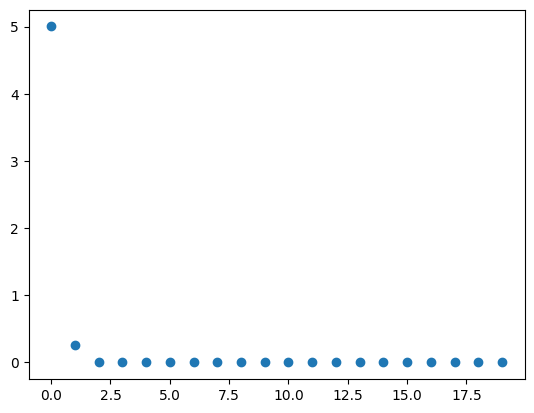

In [155]:
L, D, U = ldu(matrix)

B = -np.matmul(np.linalg.inv(D), (L + U))
F =  np.matmul(np.linalg.inv(D), f)

x, diffs = fpi(B, F, 20, matrix, f)
plt.scatter(range(len(diffs)), diffs)

## Метод Зейделя

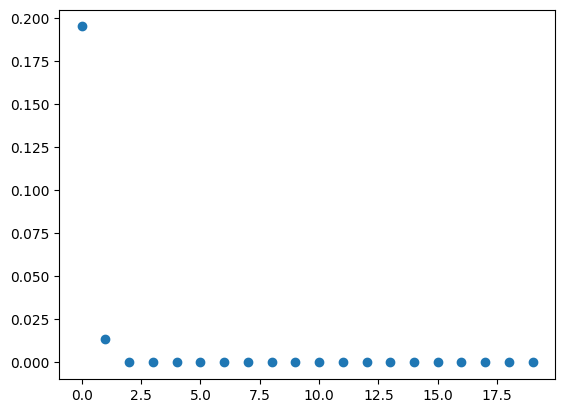

In [156]:
L, D, U = ldu(matrix)

B = -np.matmul(np.linalg.inv(L + D), U)
F =  np.matmul(np.linalg.inv(L + D), f)

x, diffs = fpi(B, F, 20, matrix, f)
plt.scatter(range(len(diffs)), diffs)

### Метод верхней релаксации

In [157]:
def sor(w):
    L, D, U = ldu(matrix)

    B = -np.matmul(np.linalg.inv(D + w * L), (w - 1) * D + w * L)
    F =  np.matmul(np.linalg.inv(D + w * L), f) * w

    x, diffs = fpi(B, F, 30, matrix, f)
    plt.scatter(range(len(diffs)), diffs)

#### Графики невязки от параметра релаксации ниже 

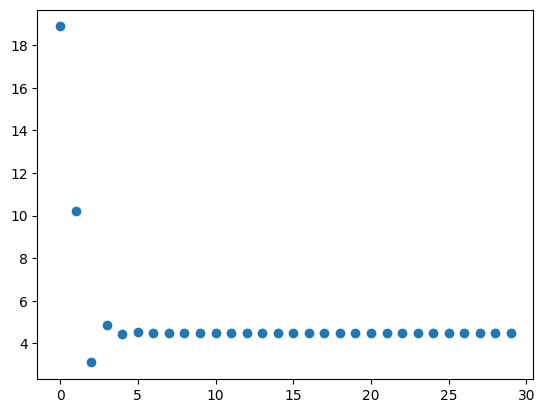

In [158]:
sor(w = 1.2)

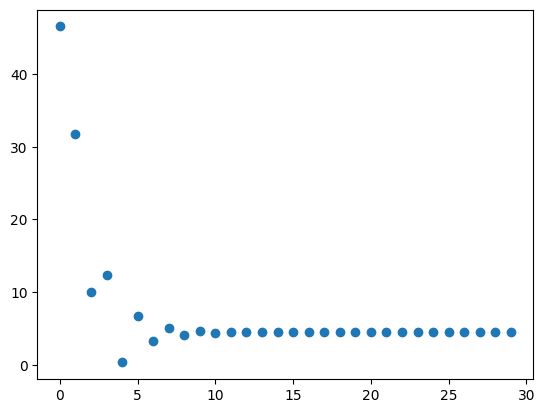

In [159]:
sor(w = 1.5)

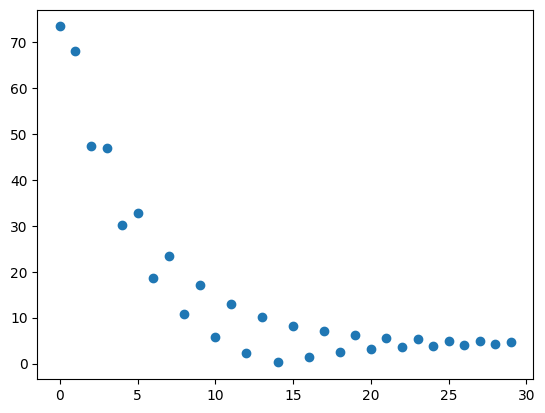

In [160]:
sor(w = 1.8)

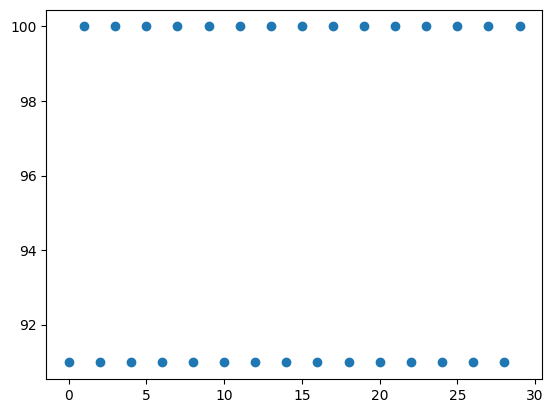

In [161]:
sor(w = 2)

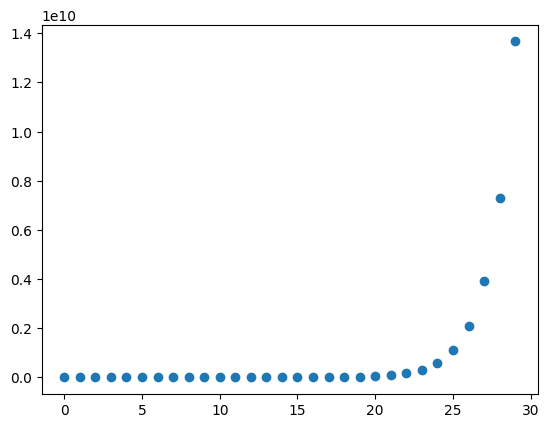

In [162]:
sor(w = 3)

#### Метод градиентного спуска

Iteration 0: Loss function = 0.2126848827535125
Iteration 100: Loss function = 0.1226625876321169
Iteration 200: Loss function = 0.11553867073633972
Iteration 300: Loss function = 0.1123700740445956
Iteration 400: Loss function = 0.11020884437971791
Iteration 500: Loss function = 0.10869440149817561
Iteration 600: Loss function = 0.10763051502540465
Iteration 700: Loss function = 0.10688207867289316
Iteration 800: Loss function = 0.10635480332572059
Iteration 900: Loss function = 0.10598277956555244


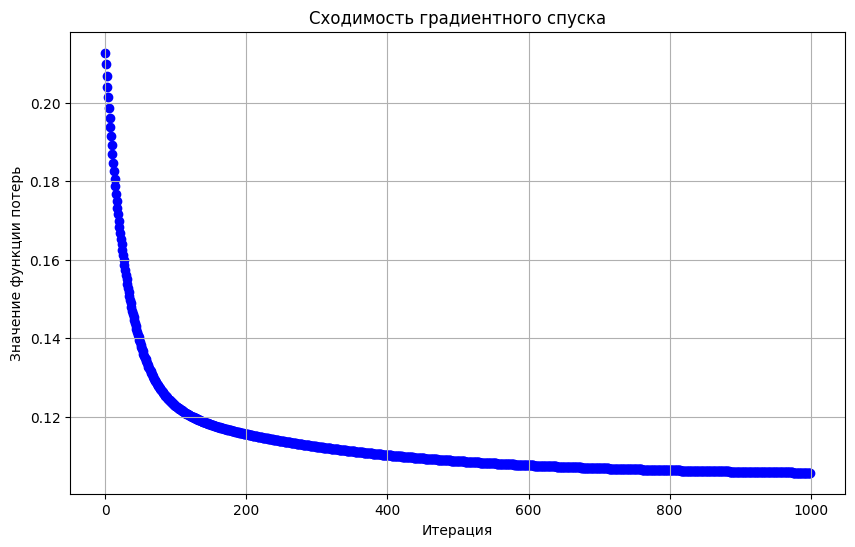

In [163]:
# Функция потерь (например, среднеквадратичная ошибка)
def loss_function(X, y, W):
    predictions = X.dot(W)
    errors = predictions - y
    loss = np.mean(errors ** 2)
    return loss

# Функция для вычисления градиента
def compute_gradient(X, y, W):
    predictions = X.dot(W)
    errors = predictions - y
    gradient = (2 / X.shape[0]) * X.T.dot(errors)
    return gradient

# Градиентный спуск с сохранением значений функции потерь
def gradient_descent(X, y, W, learning_rate, iterations):
    loss_history = []
    for i in range(iterations):
        gradient = compute_gradient(X, y, W)
        W -= learning_rate * gradient
        loss = loss_function(X, y, W)
        loss_history.append(loss)
        
        # Вывод функции потерь каждые 100 итераций
        if i % 100 == 0:
            print(f"Iteration {i}: Loss function = {loss}")
    
    return W, loss_history

# Пример данных
np.random.seed(0)
X = np.random.rand(100, 3)  
y = np.random.rand(100, 1)  
W = np.random.rand(3, 1)  

# Параметры градиентного спуска
learning_rate = 0.01
iterations = 1000

# Выполнение градиентного спуска
W_optimal, loss_history = gradient_descent(X, y, W, learning_rate, iterations)

# Построение графика функции потерь
plt.figure(figsize=(10, 6))
plt.scatter(range(iterations), loss_history, color="blue", marker="o")
plt.xlabel("Итерация")
plt.ylabel("Значение функции потерь")
plt.title("Сходимость градиентного спуска")
plt.grid(True)
plt.show()

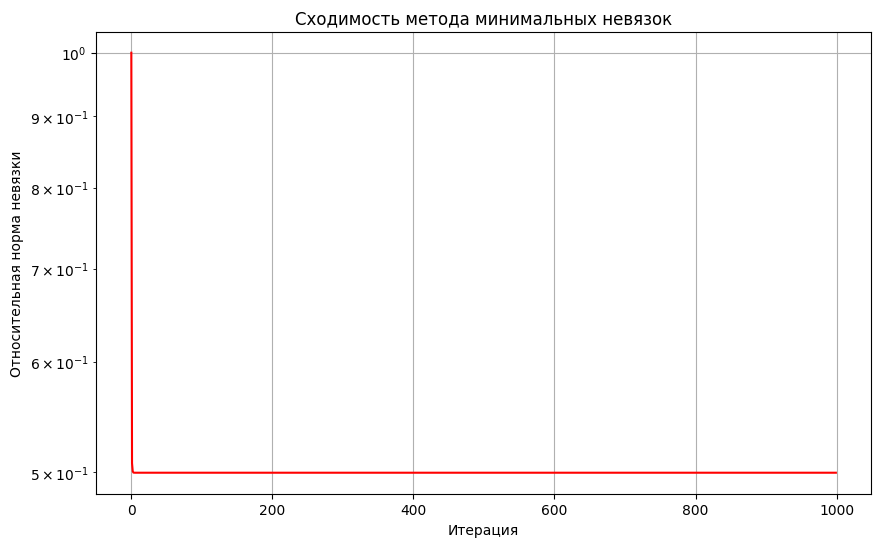

In [166]:
# Функция для вычисления невязки
def residual(A, x, b):
    return A @ x - b

# Метод минимальных невязок с оптимизацией
def minimal_residual_method(A, b, x_init, tol=1e-6, max_iterations=1000):
    x = x_init
    residuals = []
    norm_b = np.linalg.norm(b)

    for i in range(max_iterations):
        r = residual(A, x, b)  # Невязка
        residual_norm = np.linalg.norm(r) / norm_b  # Относительная норма невязки
        residuals.append(residual_norm)

        # Условие остановки по точности
        if residual_norm < tol:
            print(f"Метод завершился на итерации {i}, так как невязка меньше порога {tol}.")
            break

        # Вычисление шага альфа с проверкой знаменателя
        Ar = A @ r
        denominator = Ar.T @ Ar
        if np.isclose(denominator, 0):
            print("Знаменатель в вычислении альфа близок к нулю, метод не может продолжить.")
            break
        alpha = (r.T @ Ar) / denominator
        x = x - alpha * r

    return x, residuals

# Пример данных
np.random.seed(0)
A = np.random.rand(5, 5)
b = np.random.rand(5, 1)
x_init = np.zeros((5, 1))

# Параметры метода
tol = 1e-6
max_iterations = 1000

# Выполнение метода минимальных невязок
x_solution, residuals = minimal_residual_method(A, b, x_init, tol, max_iterations)

# Построение графика зависимости невязки от итераций
plt.figure(figsize=(10, 6))
plt.plot(range(len(residuals)), residuals, color="red")
plt.xlabel("Итерация")
plt.ylabel("Относительная норма невязки")
plt.title("Сходимость метода минимальных невязок")
plt.yscale("log")  # Логарифмическая шкала для наглядности
plt.grid(True)
plt.show()